# Predicting House Prices with Logistic Regression 📈

**Authors:** [Melissa Perez](https://github.com/MelissaPerez09), [Adrian Flores](https://github.com/adrianRFlores), [Andrea Ramirez](https://github.com/Andrea-gt)

**Description:**

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score,
precision_score, recall_score, ConfusionMatrixDisplay, classification_report, roc_curve, auc)
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegressionCV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import spearmanr
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import cProfile
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB

random_state = 42
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = figsize=(6,4)

C:\Users\agria\AppData\Local\Temp\ipykernel_22048\2571688191.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data Upload 📄

In [2]:
df = pd.read_csv('./data/train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## Feature Engineering 🗂️

### Handling Missing Values

In [3]:
# Fill missing values in low NaN count columns
df['Electrical'] = df['Electrical'].fillna('None')
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

In [4]:
# Impute missing LotFrontage values based on the median LotFrontage within each neighborhood.
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [5]:
# Fill missing values in FireplaceQu with 'None'.
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')

In [6]:
# Fill missing values in garage-related variables with 'None'.
df['GarageType'] = df['GarageType'].fillna('None')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
df['GarageFinish'] = df['GarageFinish'].fillna('None')
df['GarageQual'] = df['GarageQual'].fillna('None')
df['GarageCond'] = df['GarageCond'].fillna('None')

In [7]:
# Fill missing values in basement-related variables with 'None'.
df['BsmtQual'] = df['BsmtQual'].fillna('None')
df['BsmtCond'] = df['BsmtCond'].fillna('None')
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')

In [8]:
# Drop columns with a high count of missing values
df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

In [9]:
# Make a copy of the dataframe
df_scp = df.copy()

### Feature Creation

In [10]:
# Define conditions for categorizing SalePrice
conditions = [
    (df['SalePrice'] < 150000),
    (df['SalePrice'] >= 150000) & (df['SalePrice'] <= 250000),
    (df['SalePrice'] > 250000)
]

# Define labels for the categories
labels = ['economical', 'intermediate', 'expensive']

# Create a new column 'SalePriceCategory' based on the conditions and labels
df['SalePriceCategory'] = np.select(conditions, labels)

df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePriceCategory
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2,2008,WD,Normal,208500,intermediate
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,5,2007,WD,Normal,181500,intermediate
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,9,2008,WD,Normal,223500,intermediate
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,2,2006,WD,Abnorml,140000,economical
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,12,2008,WD,Normal,250000,intermediate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,8,2007,WD,Normal,175000,intermediate
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2,2010,WD,Normal,210000,intermediate
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,2500,5,2010,WD,Normal,266500,expensive
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,4,2010,WD,Normal,142125,economical


### Feature Encoding

In [11]:
# Columns to encode, separated by feature category
nominalFeatures = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
                    'Heating', 'CentralAir', 'Electrical', 'GarageType', 'SaleType',
                    'SaleCondition','PavedDrive', 'SalePriceCategory']

ordinalFeatures = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual','FireplaceQu', 'GarageQual', 'GarageCond']

otherOrdinalFeatures = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish']

In [12]:
# Convert nominal features into dummy variables
# Get dummies for nominal features
dummies = pd.get_dummies(df[nominalFeatures])
dummies.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SalePriceCategory_economical,SalePriceCategory_expensive,SalePriceCategory_intermediate
0,False,False,False,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True
1,False,False,False,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,True
2,False,False,False,True,False,False,True,True,False,False,...,False,False,True,False,False,False,True,False,False,True
3,False,False,False,True,False,False,True,True,False,False,...,False,False,False,False,False,False,True,True,False,False
4,False,False,False,True,False,False,True,True,False,False,...,False,False,True,False,False,False,True,False,False,True


In [13]:
# Drop the original nominal features columns
df = df.drop(nominalFeatures, axis=1)

# Concatenate dummies with original DataFrame
df = pd.concat([df, dummies], axis=1)
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SalePriceCategory_economical,SalePriceCategory_expensive,SalePriceCategory_intermediate
0,1,60,65.0,8450,7,5,2003,2003,196.0,Gd,...,False,False,True,False,False,False,True,False,False,True
1,2,20,80.0,9600,6,8,1976,1976,0.0,TA,...,False,False,True,False,False,False,True,False,False,True
2,3,60,68.0,11250,7,5,2001,2002,162.0,Gd,...,False,False,True,False,False,False,True,False,False,True
3,4,70,60.0,9550,7,5,1915,1970,0.0,TA,...,False,False,False,False,False,False,True,True,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,Gd,...,False,False,True,False,False,False,True,False,False,True


In [14]:
# Initialize the OrdinalEncoder
encoder = OrdinalEncoder()

# Define ordinal categories
ordinalCategories = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

# Reshape the ordinal categories array
ordinalCategories = np.array(ordinalCategories).reshape(-1, 1)

# Fit the encoder to the ordinal categories
encoder.fit(ordinalCategories)

# Encode columns to in ordinalFeatures
for feature in ordinalFeatures:
    df[[feature]] = encoder.transform(df[[feature]])

df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SalePriceCategory_economical,SalePriceCategory_expensive,SalePriceCategory_intermediate
0,1,60,65.0,8450,7,5,2003,2003,196.0,2.0,...,False,False,True,False,False,False,True,False,False,True
1,2,20,80.0,9600,6,8,1976,1976,0.0,5.0,...,False,False,True,False,False,False,True,False,False,True
2,3,60,68.0,11250,7,5,2001,2002,162.0,2.0,...,False,False,True,False,False,False,True,False,False,True
3,4,70,60.0,9550,7,5,1915,1970,0.0,5.0,...,False,False,False,False,False,False,True,True,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,2.0,...,False,False,True,False,False,False,True,False,False,True


In [15]:
# Define encoding categories for each other ordinal feature
encodingCategories = [
    ['None', 'No', 'Mn', 'Av', 'Gd'],  # BsmtExposure
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType1
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # BsmtFinType2
    ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], # Functional
    ['None', 'Unf', 'RFn', 'Fin']  # GarageFinish
]

# Reshape the ordinal categories array
reshapedEncodingCategories = [np.array(categories).reshape(-1, 1) for categories in encodingCategories]

# Encode columns in otherOrdinalFeatures
for feature, categories in zip(otherOrdinalFeatures, reshapedEncodingCategories):
    # Fit the encoder to the encoding categories
    encoder.fit(categories)
    df[[feature]] = encoder.transform(df[[feature]])

df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SalePriceCategory_economical,SalePriceCategory_expensive,SalePriceCategory_intermediate
0,1,60,65.0,8450,7,5,2003,2003,196.0,2.0,...,False,False,True,False,False,False,True,False,False,True
1,2,20,80.0,9600,6,8,1976,1976,0.0,5.0,...,False,False,True,False,False,False,True,False,False,True
2,3,60,68.0,11250,7,5,2001,2002,162.0,2.0,...,False,False,True,False,False,False,True,False,False,True
3,4,70,60.0,9550,7,5,1915,1970,0.0,5.0,...,False,False,False,False,False,False,True,True,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,2.0,...,False,False,True,False,False,False,True,False,False,True


## Log. Regression Models

### Initial Iteration - Identifying House Pricings (Using All Variables)

#### Splitting DataSets for First Iteration

In [16]:
# Make another copy of the dataframe
df_cp = df.copy()

# Expensive DataSet Splitting
# Separate the target variable 'SalePriceCategory' from features
y_expensive = df_cp.pop('SalePriceCategory_expensive')

# Exclude columns 'Id' and SalePriceCategory(s) from features
X_expensive = df_cp.loc[:, ~df_cp.columns.isin(['Id', 'SalePrice', 'SalePriceCategory_economical', 'SalePriceCategory_intermediate'])]

In [17]:
# Intermediate DataSet Splitting
# Make another copy of the dataframe
df_cp = df.copy()

# Separate the target variable 'SalePriceCategory' from features
y_intermediate = df_cp.pop('SalePriceCategory_intermediate')

# Exclude columns 'Id' and SalePriceCategory(s) from features
X_intermediate = df_cp.loc[:, ~df_cp.columns.isin(['Id', 'SalePrice', 'SalePriceCategory_economical', 'SalePriceCategory_expensive'])]

In [18]:
# Economical DataSet Splitting
# Make another copy of the dataframe
df_cp = df.copy()

# Separate the target variable 'SalePriceCategory' from features
y_economical = df_cp.pop('SalePriceCategory_economical')

# Exclude columns 'Id' and SalePriceCategory(s) from features
X_economical = df_cp.loc[:, ~df_cp.columns.isin(['Id', 'SalePrice', 'SalePriceCategory_intermediate', 'SalePriceCategory_expensive'])]

In [19]:
# Expensive DataSet Splitting
# Split the data into training and testing sets
X_train_expensive, X_test_expensive, y_train_expensive, y_test_expensive = train_test_split(X_expensive, y_expensive, test_size=0.2, train_size=0.8, random_state=random_state)

In [20]:
# Intermediate DataSet Splitting
# Split the data into training and testing sets
X_train_intermediate, X_test_intermediate, y_train_intermediate, y_test_intermediate = train_test_split(X_intermediate, y_intermediate,
                                                                                                        test_size=0.2, train_size=0.8, random_state=random_state)

In [21]:
# Economical DataSet Splitting
# Split the data into training and testing sets
X_train_economical, X_test_economical, y_train_economical, y_test_economical = train_test_split(X_economical, y_economical,
                                                                                                test_size=0.2, train_size=0.8, random_state=random_state)

In [22]:
print(X_train_expensive.shape)
print(X_test_expensive.shape)

(1168, 224)
(292, 224)


In [23]:
print(X_train_intermediate.shape)
print(X_test_intermediate.shape)

(1168, 224)
(292, 224)


In [24]:
print(X_train_intermediate.shape)
print(X_test_intermediate.shape)

(1168, 224)
(292, 224)


#### First Iteration - Logistic Regression Models (All Features)

##### Logistic Regression Models

**Expensive Houses Logistic Regression Model**

In [25]:
# Initialize Logistic Regression model with cross-validation
clf_ex = LogisticRegressionCV(random_state=random_state, solver='liblinear', max_iter=1000)

def train_model():
    # Fit the expensive model to the training data
    clf_expensive = clf_ex.fit(X_train_expensive, y_train_expensive)

    return clf_expensive

print('Training time taken:')
cProfile.run('clf_expensive = train_model()')

Training time taken:
         71553 function calls (71353 primitive calls) in 14.257 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   14.217   14.217 3110223355.py:4(train_model)
        5    0.000    0.000    0.000    0.000 <frozen _collections_abc>:104(_check_methods)
        1    0.000    0.000    0.000    0.000 <frozen _collections_abc>:288(__subclasshook__)
        5    0.000    0.000    0.000    0.000 <frozen _collections_abc>:309(__subclasshook__)
       19    0.000    0.000    0.000    0.000 <frozen _collections_abc>:341(__subclasshook__)
        1    0.000    0.000    0.000    0.000 <frozen _collections_abc>:388(__subclasshook__)
       38    0.000    0.000    0.000    0.000 <frozen _collections_abc>:435(__subclasshook__)
      640    0.000    0.000    0.003    0.000 <frozen abc>:117(__instancecheck__)
  417/350    0.000    0.000    0.001    0.000 <frozen abc>:121(__subclasscheck__)
   

In [26]:
def predict():
    # Predict the target variable using the model on the train data
    y_test_pred_expensive = clf_ex.predict(X_test_expensive)
    return y_test_pred_expensive, y_train_pred_expensive

# Predict the target variable using the trained model on the train data
y_train_pred_expensive = clf_expensive.predict(X_train_expensive)

print('Prediction time taken:')
cProfile.run('y_test_pred_expensive = predict()')

Prediction time taken:
         31081 function calls (30961 primitive calls) in 0.055 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.055    0.055 1207712574.py:1(predict)
        2    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        2    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
      306    0.001    0.000    0.001    0.000 <frozen importlib._bootstrap>:1390(_handle_fromlist)
        1    0.000    0.000    0.055    0.055 <string>:1(<module>)
       24    0.000    0.000    0.000    0.000 __init__.py:34(using_copy_on_write)
        2    0.000    0.000    0.000    0.000 _array_api.py:111(_is_numpy_namespace)
        2    0.000    0.000    0.000    0.000 _array_api.py:123(isdtype)
        2    0.000    0.000    0.000    0.000 _array_api.py:130(<genexpr>)
        2    0.000    0.000    0.000    0.000 _array_api.py:135(_isdtype_single)
      

**Intermediate Houses Logistic Regression Model**

In [27]:
# Initialize Logistic Regression model with cross-validation
clf_in = LogisticRegressionCV(random_state=random_state, solver='liblinear', max_iter=1000)

# Fit the intermediate model to the training data
clf_intermediate = clf_in.fit(X_train_intermediate, y_train_intermediate)

# Predict the target variable using the model on the test data
y_test_pred_intermediate = clf_in.predict(X_test_intermediate)

# Predict the target variable using the model on the train data
y_train_pred_intermediate = clf_intermediate.predict(X_train_intermediate)

**Economical Houses Logistic Regression Model**

In [28]:
# Initialize Logistic Regression model with cross-validation
clf_ec = LogisticRegressionCV(random_state=random_state, solver='liblinear', max_iter=1000)

# Fit the economical model to the training data
clf_economical = clf_ec.fit(X_train_economical, y_train_economical)

# Predict the target variable using the model on the test data
y_test_pred_economical = clf_economical.predict(X_test_economical)

# Predict the target variable using the model on the train data
y_train_pred_economical = clf_economical.predict(X_train_economical)

##### Results, Findings and Insights

In [29]:
# Accuracy scores for test set
print("Accuracy Scores on Test Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_test_expensive, y_test_pred_expensive)))
print("Intermediate Houses Classifier: {:.2f}".format(accuracy_score(y_test_intermediate, y_test_pred_intermediate)))
print("Economical Houses Classifier: {:.2f}".format(accuracy_score(y_test_economical, y_test_pred_economical)))
print()

# Accuracy scores for train set
print("Accuracy Scores on Train Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_train_expensive, y_train_pred_expensive)))
print("Intermediate Houses Classifier: {:.2f}".format(accuracy_score(y_train_intermediate, y_train_pred_intermediate)))
print("Economical Houses Classifier: {:.2f}".format(accuracy_score(y_train_economical, y_train_pred_economical)))

Accuracy Scores on Test Set:
---------------------------------------
Expensive Houses Classifier: 0.94
Intermediate Houses Classifier: 0.79
Economical Houses Classifier: 0.93

Accuracy Scores on Train Set:
---------------------------------------
Expensive Houses Classifier: 0.97
Intermediate Houses Classifier: 0.83
Economical Houses Classifier: 0.95


A través de un detallado análisis de los resultados obtenidos mediante la aplicación de los diversos modelos de clasificación de casas en los conjuntos de prueba y de testeo, se muestras importantes insights acerca de su rendimiento y capacidad de generalización de datos.

1. Clasificador de Casas de Gama Alta:

    - Se evidencia una precisión de 0.95 para el conjunto de datos de testeo.
    - Se evidencia una precisión de 0.97 para el conjunto de datos de prueba.

      El modelo de regresión logística aplicado a la clasificación de casas de gama alta exhibe un nivel de precisión notable tanto en el conjunto de datos de prueba como en el de entrenamiento. Esto sugiere que el modelo desarrollado posee la capacidad de generalizar adecuadamente datos no observados previamente. Es importante destacar que se observa una ligera disminución en la precisión del modelo al aplicarlo al conjunto de datos de prueba en comparación con el de entrenamiento, lo cual podría indicar un mínima sobreajuste en el modelo. Esta discrepancia puede surgir debido a la presencia de ruido en el conjunto de datos de entrenamiento. En este contexto, resulta escencial considerar la implementación de técnicas de regularización, las cuales serán abordadas más adelante en este documento.

      No obstante, en líneas generales, el modelo muestra un desempeño sobresaliente y métricas bastante alentadoras. El elevado nivel de precisión obtenido sugiere que las características empleadas en la construcción del modelo son capaces de identificar y distinguir de manera precisa las casas de gama alta del resto.

2. Clasificador de Casas de Gama Media:

    - Se evidencia una precisión de 0.80 para el conjunto de datos de testeo.
    - Se evidencia una precisión de 0.83 para el conjunto de datos de prueba.

      El modelo de regresión logística aplicado a la clasificación de casas de gama media también exhibe un nivel de precisión considerablemente bueno en ambos conjuntos de datos. Sin embargo, es en este modelo en donde se evidencia una disminución notable en la precisión cuando el modelo es aplicado en el conjunto de datos de testeo. Nuevamente, esto sugiere la existencia de un sobreajuste, posiblemente más grande que el del modelo descrito con anterioridad. Aunque no es alarmante, y el modelo brinda resultados aceptables, es posible inferir que está teniendo problemas al generalizar la data que aún no ha visto. Puede que esita una ventana de mejora en la selección de características.  

3. Clasificador de Casas Económicas:

    - Se evidencia una precisión de 0.92 para el conjunto de datos de testeo.
    - Se evidencia una precisión de 0.95 para el conjunto de datos de prueba.
  
      El modelo de regresión logística aplicado a la clasificación de casas económicas exhibe un nivel de precisión excelente en ambos conjuntos de datos. Aunque también se percibe cierto nivel de sobreajuste, este es mínimo.

**Logistic Regression Model to Identify Expensive Houses - Results**

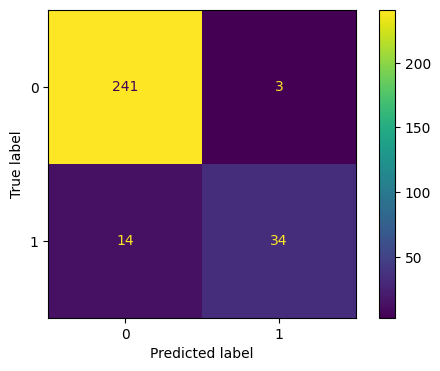

In [30]:
# Logistic Regression Model to Identify Expensive Houses
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_test_expensive, y_test_pred_expensive)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de prueba:
- Para la clase 0 (casas económicas e intermedias), se clasificaron correctamente 241 casos.
- Para la clase 1 (casas de gama alta), se clasificaron correctamente 35 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- El modelo se equivocó más frecuentemente en la predicción de casas de gama alta (clase 1), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas de gama media y baja (clase 0), ya que tiene el menor número de clasificaciones erróneas totales.

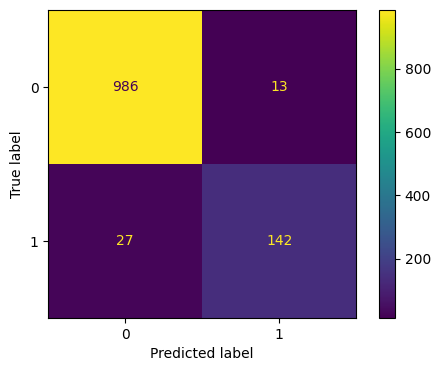

In [31]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_train_expensive, y_train_pred_expensive)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de entrenamiento:
- Para la clase 0 (casas económicas y de gama media), se clasificaron correctamente 989 casos.
- Para la clase 1 (casas de gama alta), se clasificaron correctamente 141 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- El modelo se equivocó más frecuentemente en la predicción de casas de gama alta (clase 1), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas económicas y de gama media (clase 0), ya que tiene el menor número de clasificaciones erróneas totales.

Los errores de clasificación, en el contexto de la predicción de casas de gama alta, pueden tener implicaciones financieras. Identificar y corregir las fuentes de error en la predicción de casas de gama alta puede ser crucial para mejorar la rentabilidad y la satisfacción del cliente en el mercado inmobiliario.

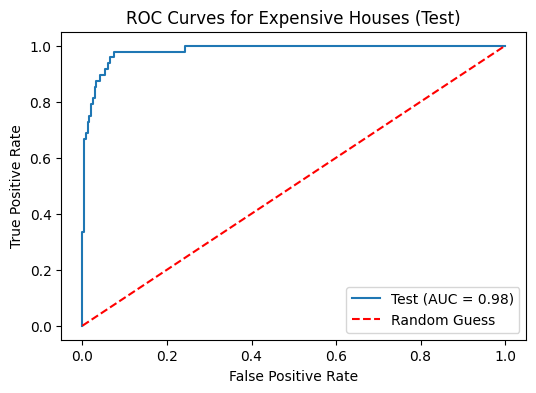

In [32]:
y_pred1 = clf_ex.predict_proba(X_test_expensive)[:,1]
#y_pred2 = clf_ex.predict_proba(X_train_expensive)[:,1]

test_df = pd.DataFrame(
    {'True': y_test_expensive, 'Test': y_pred1})

for model in ['Test']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Expensive Houses (Test)')
plt.legend()
plt.show()

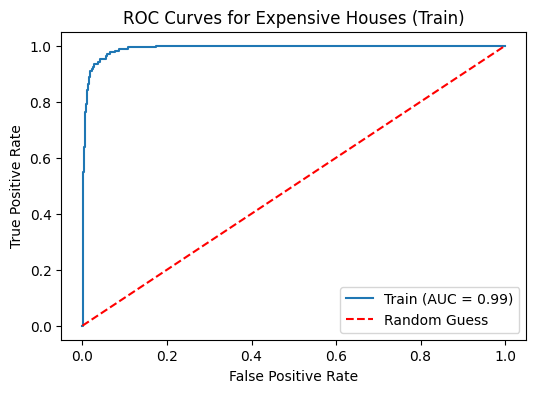

In [33]:
y_pred1 = clf_ex.predict_proba(X_train_expensive)[:,1]

test_df = pd.DataFrame(
    {'True': y_train_expensive, 'Train': y_pred1})

for model in ['Train']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Expensive Houses (Train)')
plt.legend()
plt.show()

Un AUC (Área bajo la curva ROC) de 0.98 en el conjunto de datos de prueba y de 0.99 en el conjunto de datos de entrenamiento indica que el modelo de regresión logística está teniendo un excelente desempeño en la clasificación binaria.

**AIC y BIC**

In [34]:
X = X_expensive.copy()
y = y_expensive.copy()

for col in X.columns:
    if X[col].dtype == 'object':
        X = pd.concat([X, pd.get_dummies(X[col], prefix=col)], axis=1)
        X.drop([col], axis=1, inplace=True)
    else:
        X[col] = pd.to_numeric(X[col], errors='coerce')

X = X.select_dtypes(['number'])

model = sm.Logit(y, X).fit(method='bfgs')

print("AIC:", model.aic)
print("BIC:", model.bic)

         Current function value: 0.125075
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 41
AIC: 461.21896576430476
BIC: 714.9561680700191


**Logistic Regression Model to Identify Intermediate Houses - Results**

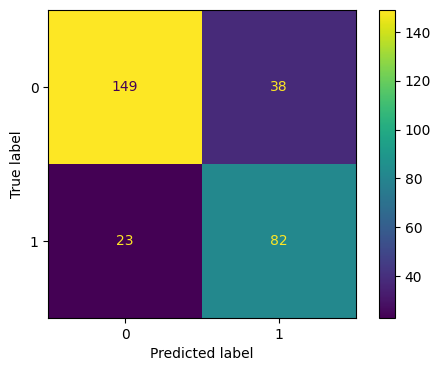

In [35]:
# Logistic Regression Model to Identify Intermediate Houses
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_test_intermediate, y_test_pred_intermediate)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de prueba:
- Para la clase 0 (casas económicas y de gama alta), se clasificaron correctamente 149 casos.
- Para la clase 1 (casas de gama media), se clasificaron correctamente 84 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- El modelo se equivocó más frecuentemente en la predicción de casas económicas y de gama alta (clase 0), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas de gama media (clase 1), ya que tiene el menor número de clasificaciones erróneas totales.

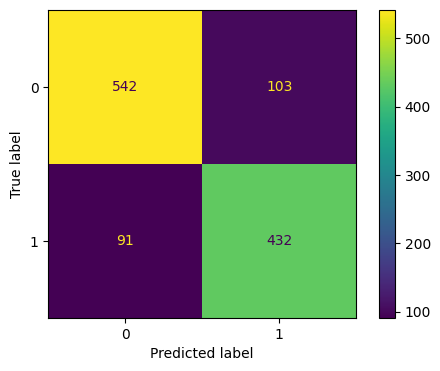

In [36]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_train_intermediate, y_train_pred_intermediate)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de entrenamiento:
- Para la clase 0 (casas económicas y de gama alta), se clasificaron correctamente 542 casos.
- Para la clase 1 (casas de gama media), se clasificaron correctamente 430 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- El modelo se equivocó más frecuentemente en la predicción de casas económicas y de gama alta (clase 0), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas de gama media (clase 1), ya que tiene el menor número de clasificaciones erróneas totales.

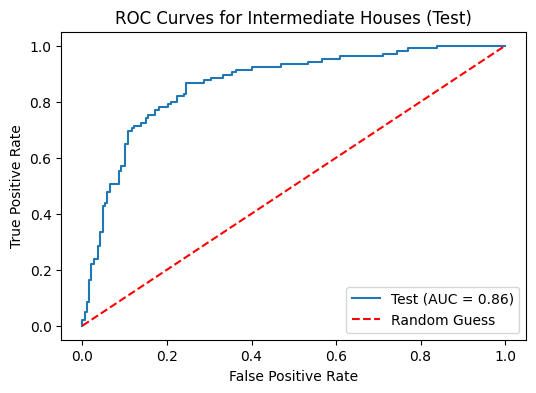

In [37]:
y_pred1 = clf_in.predict_proba(X_test_intermediate)[:,1]

test_df = pd.DataFrame(
    {'True': y_test_intermediate, 'Test': y_pred1})

for model in ['Test']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Intermediate Houses (Test)')
plt.legend()
plt.show()

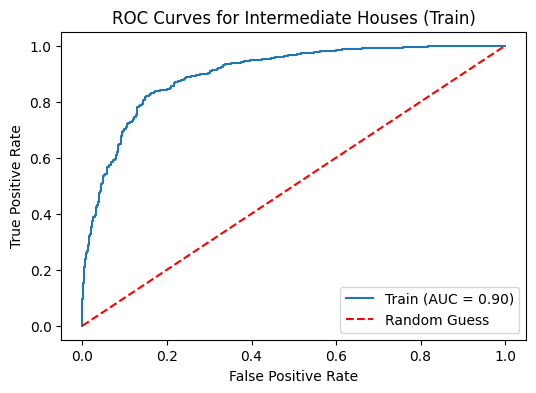

In [38]:
y_pred1 = clf_in.predict_proba(X_train_intermediate)[:,1]

test_df = pd.DataFrame(
    {'True': y_train_intermediate, 'Train': y_pred1})

for model in ['Train']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Intermediate Houses (Train)')
plt.legend()
plt.show()

El modelo de regresión logística para clasificar casas de gama media muestra un buen rendimiento con un AUC de 0.86 en el conjunto de datos de prueba y 0.90 en el conjunto de entrenamiento, aunque la discrepancia entre ambos sugiere posible sobreajuste.

**Logistic Regression Model to Identify Economical Houses - Results**

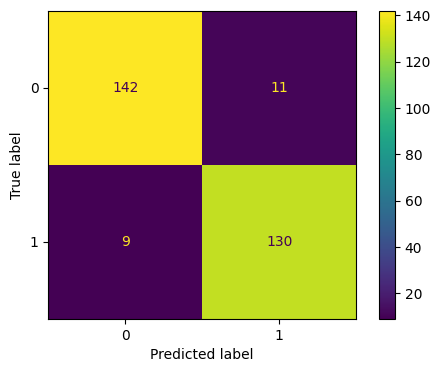

In [39]:
# Logistic Regression Model to Identify Economical Houses
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_test_economical, y_test_pred_economical)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de prueba:
- Para la clase 0 (casas de gama media y alta), se clasificaron correctamente 140 casos.
- Para la clase 1 (casas económicas), se clasificaron correctamente 128 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- El modelo se equivocó más frecuentemente en la predicción de casas de gama media y alta (clase 0), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas económicas (clase 1), ya que tiene el menor número de clasificaciones erróneas totales.

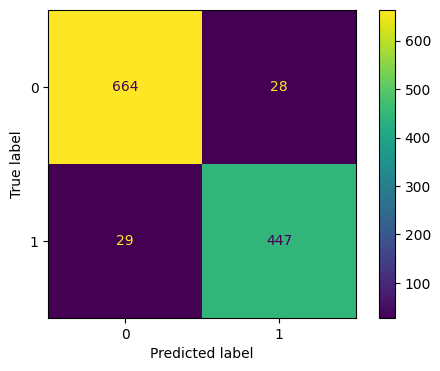

In [40]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_train_economical, y_train_pred_economical)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de entrenamiento:
- Para la clase 0 (casas de gama media y alta), se clasificaron correctamente 666 casos.
- Para la clase 1 (casas económicas), se clasificaron correctamente 449 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- El modelo se equivocó más frecuentemente en la predicción de casas económicas (clase 1), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas de gama media y alta (clase 0), ya que tiene el menor número de clasificaciones erróneas totales.

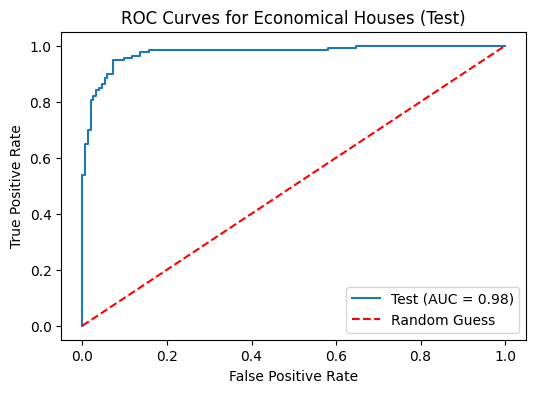

In [41]:
y_pred1 = clf_ec.predict_proba(X_test_economical)[:,1]

test_df = pd.DataFrame(
    {'True': y_test_economical, 'Test': y_pred1})

for model in ['Test']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Economical Houses (Test)')
plt.legend()
plt.show()

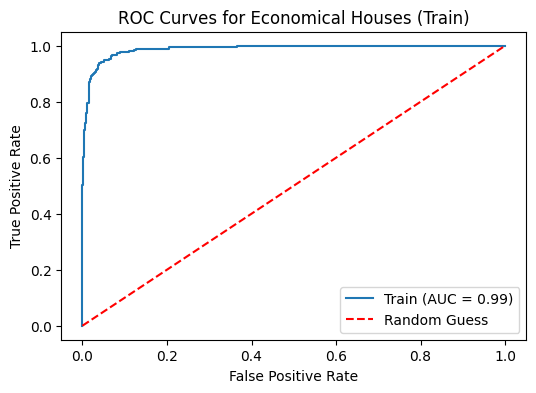

In [42]:
y_pred1 = clf_ec.predict_proba(X_train_economical)[:,1]

test_df = pd.DataFrame(
    {'True': y_train_economical, 'Train': y_pred1})

for model in ['Train']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Economical Houses (Train)')
plt.legend()
plt.show()

El modelo de regresión logística para clasificar casas de gama económica exhibe un rendimiento sólido, como lo indica un AUC de 0.97 en el conjunto de datos de prueba y de 0.99 en el conjunto de entrenamiento. La ligera discrepancia entre ambos conjuntos podría sugerir una posible sobreajuste, pero dado que ambos valores son altos, el modelo aún demuestra una capacidad robusta de generalización.

En el contexto de la predicción del precio de las viviendas, los errores de clasificación son fuertemente significativos, dada su capacidad para generar consecuencias adversas. Estos errores podrían desencadenar decisiones financieras erróneas, lo que potencialmente conduciría a péridas. Además, podrían impactar de manera negativa la experiencia y satisfacción de clientes del mercado inmobiliario. Por consiguiente, la identificación y corrección de las fuentes de error en la predicción de los precios de las casas es crucial.

### Second Iteration - Identifying House Pricings (With Feature Engineering)

##### Multicollinearity Analysis Using Variance Inflation Factor (VIF) and HeatMaps

In [43]:
# Select only the boolean columns
test = X_train_expensive.select_dtypes(include='number')
test

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
254,20,70.0,8400,5,6,1957,1957,0.0,5.0,2.0,...,5.0,250,0,0,0,0,0,0,6,2010
1066,60,59.0,7837,6,7,1993,1994,0.0,2.0,5.0,...,5.0,0,40,0,0,0,0,0,5,2009
638,30,67.0,8777,5,7,1910,1950,0.0,5.0,5.0,...,3.0,328,0,164,0,0,0,0,5,2008
799,50,60.0,7200,5,7,1937,1950,252.0,5.0,5.0,...,5.0,0,0,264,0,0,0,0,6,2007
380,50,50.0,5000,5,6,1924,1950,0.0,5.0,5.0,...,5.0,0,0,242,0,0,0,0,5,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,20,78.0,9317,6,5,2006,2006,0.0,2.0,5.0,...,5.0,0,22,0,0,0,0,0,3,2007
1130,50,65.0,7804,4,3,1928,1950,0.0,5.0,5.0,...,5.0,431,44,0,0,0,0,0,12,2009
1294,20,60.0,8172,5,7,1955,1990,0.0,5.0,5.0,...,5.0,0,0,0,0,0,0,0,4,2006
860,50,55.0,7642,7,8,1918,1998,0.0,2.0,5.0,...,5.0,0,240,0,0,0,0,0,6,2007


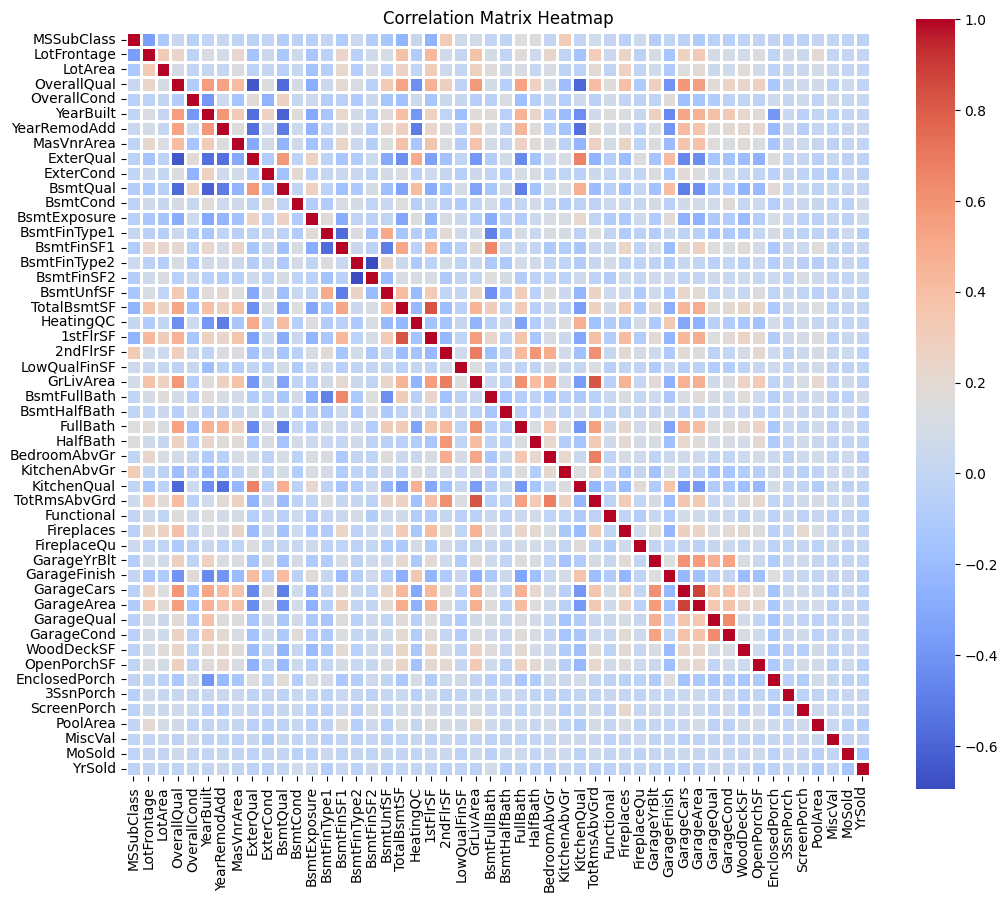

In [44]:
corrMatrix = test.corr()
tidy_corr_matrix = corrMatrix.reset_index().melt(id_vars='index').rename(columns={'index': 'Variable 1', 'variable': 'Variable 2', 'value': 'Correlation'})
tidy_corr_matrix = tidy_corr_matrix[tidy_corr_matrix['Variable 1'] != tidy_corr_matrix['Variable 2']]

plt.figure(figsize=(12, 10))
sns.heatmap(corrMatrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

Se ha generado un mapa de calor utilizando los atributos originales del modelo previo, como se ha mostrado anteriormente, con el propósito de examinar la posible presencia de multicolinealidad. Los resultados revelan que, si bien no se observa una multicolinealidad extrema entre las distintas características, aún subsisten algunas que están notablemente correlacionadas, presentando coeficientes de correlación superiores a ±0.6.

In [45]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = test.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(test.values, i) for i in range(len(test.columns))]

In [46]:
vif_data

,feature,VIF
0,MSSubClass,4.956506e+00
1,LotFrontage,1.743233e+01
2,LotArea,2.572774e+00
3,OverallQual,7.773594e+01
4,OverallCond,4.528090e+01
5,YearBuilt,2.201767e+04
6,YearRemodAdd,2.381988e+04
7,MasVnrArea,1.970812e+00
8,ExterQual,1.833422e+01
9,ExterCond,2.323342e+01


Con el fin de profundizar en la evaluación de la posible multicolinealidad, se lleva a cabo un análisis más exhaustivo mediante el cálculo del Factor de Inflación de la Varianza (VIF). Este factor proporciona una medida de la intensidad de la correlación entre las variables independientes en un modelo de regresión. Específicamente, el VIF cuantifica cuánto aumenta la varianza de un coeficiente de regresión debido a la multicolinealidad entre esa variable y las demás.

Los resultados obtenidos revelan que ciertas características independientes muestran una correlación perfecta entre sí, lo que conlleva a que presenten un VIF de infinito. Este hallazgo confirma de manera contundente la existencia de multicolinealidad severa en el conjunto de datos. La presencia de tales relaciones altamente correlacionadas puede distorsionar significativamente la interpretación de los coeficientes de regresión y afectar la fiabilidad de las inferencias realizadas a partir del modelo. Es esencial abordar esta problemática para garantizar la validez y precisión de los análisis, por lo que se procede a realizar feature engineering.

In [47]:
tempTest = test.copy()

# Create a new column 'OverallQuality' by averaging the values of quality-related features
tempTest['OverallQuality'] = tempTest[['OverallQual', 'OverallCond', 'ExterQual', 'BsmtQual', 'BsmtCond', 'KitchenQual']].mean(axis=1)

# Combine the number of full baths and half baths into a new feature 'TotalBaths'
tempTest['TotalBaths'] = tempTest['FullBath'] + 0.5 * tempTest['HalfBath'] + tempTest['BsmtFullBath'] + 0.5 * tempTest['BsmtHalfBath']

# Binary feature indicating whether the house was remodeled or not.
tempTest['Age'] = (tempTest['YrSold'] != tempTest['YearBuilt']).astype(int)

# Binary feature indicating whether the house was remodeled or not.
tempTest['Remodeled'] = (tempTest['YearRemodAdd'] != tempTest['YearBuilt']).astype(int)

# List of columns to drop
columnstoDrop = ['1stFlrSF', '2ndFlrSF', 'YearRemodAdd', 'GarageCond', 'YrSold', 'GarageCars', 'FireplaceQu', 'TotRmsAbvGrd',
                 'FireplaceQu', 'GarageYrBlt', 'KitchenQual', 'ExterCond', 'ExterQual', 'BsmtQual', 'BsmtCond', 'YearBuilt',
                 'KitchenAbvGr', 'BedroomAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'GarageQual', 'GarageArea', 'OverallQual',
                  'Functional', 'BsmtUnfSF', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF',
                 'LotFrontage', 'PoolArea', 'GrLivArea', 'FullBath', 'HalfBath', 'GarageFinish', 'OverallCond']

# Drop the specified columns
tempTest = tempTest.drop(columns=columnstoDrop)
tempTest

,MSSubClass,LotArea,MasVnrArea,BsmtExposure,BsmtFinType1,HeatingQC,LowQualFinSF,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,OverallQuality,TotalBaths,Age,Remodeled
254,20,8400,0.0,3.0,5.0,5.0,0,0,250,0,0,0,0,0,6,5.166667,2.0,1,0
1066,60,7837,0.0,3.0,6.0,2.0,0,1,0,40,0,0,0,0,5,4.500000,2.5,1,1
638,30,8777,0.0,3.0,6.0,2.0,0,0,328,0,164,0,0,0,5,4.666667,1.0,1,1
799,50,7200,252.0,3.0,0.0,0.0,0,2,0,0,264,0,0,0,6,4.333333,2.5,1,1
380,50,5000,0.0,3.0,3.0,5.0,0,1,0,0,242,0,0,0,5,4.666667,2.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,20,9317,0.0,3.0,2.0,2.0,0,1,0,22,0,0,0,0,3,3.666667,2.0,1,0
1130,50,7804,0.0,3.0,1.0,5.0,0,2,431,44,0,0,0,0,12,4.000000,3.0,1,1
1294,20,8172,0.0,3.0,5.0,5.0,0,0,0,0,0,0,0,0,4,5.333333,2.0,1,1
860,50,7642,0.0,3.0,6.0,2.0,0,1,0,240,0,0,0,0,6,4.833333,1.5,1,1


Es importante notar que algunas de las características pueden ser fusionadas mediante feature engineering para formar una única variable compuesta. Este enfoque podría ayudar a mitigar la multicolinealidad al reducir la redundancia de la información contenida en las variables originales. Al combinar características relacionadas en una sola, se preserva la información relevante mientras se disminuye la interdependencia entre variables.

In [48]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Feature"] = tempTest.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(tempTest.values, i) for i in range(len(tempTest.columns))]
vif_data

,Feature,VIF
0,MSSubClass,3.043490
1,LotArea,2.307802
2,MasVnrArea,1.604541
3,BsmtExposure,5.865881
4,BsmtFinType1,3.145151
5,HeatingQC,2.285103
6,LowQualFinSF,1.045827
7,Fireplaces,2.465724
8,WoodDeckSF,1.833222
9,OpenPorchSF,1.726589


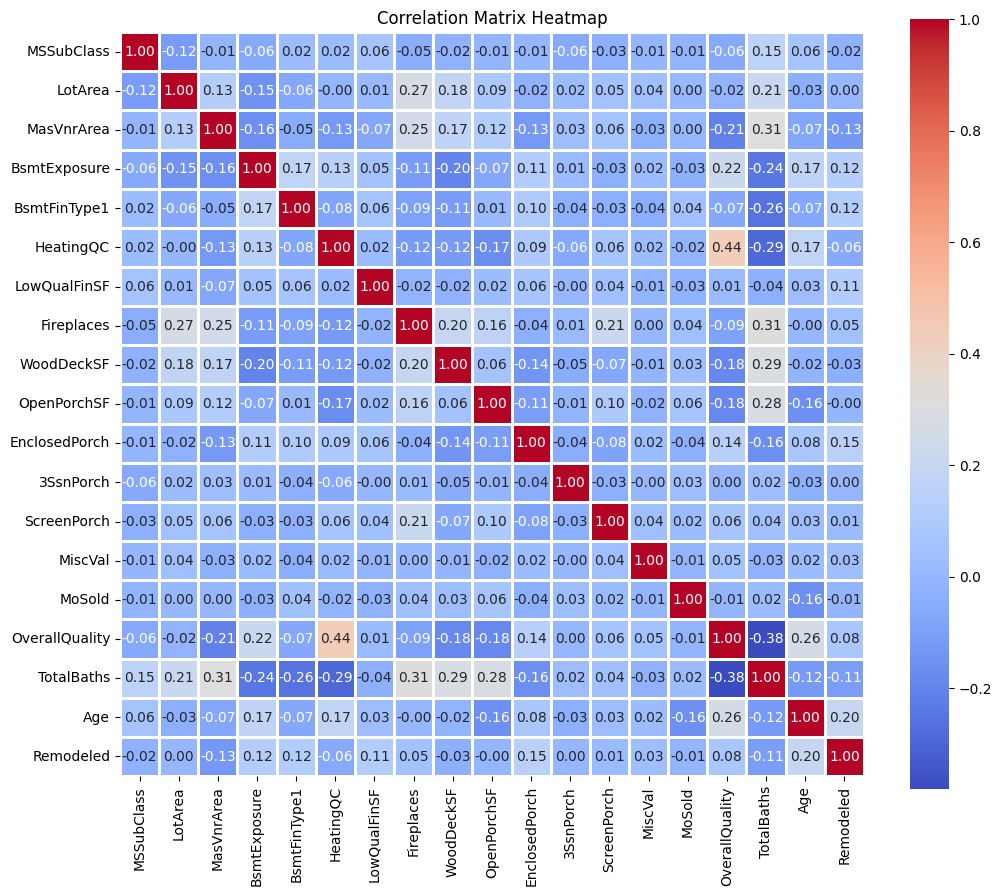

In [49]:
corrMatrix = tempTest.corr()
tidy_corr_matrix = corrMatrix.reset_index().melt(id_vars='index').rename(columns={'index': 'Variable 1', 'variable': 'Variable 2', 'value': 'Correlation'})
tidy_corr_matrix = tidy_corr_matrix[tidy_corr_matrix['Variable 1'] != tidy_corr_matrix['Variable 2']]

plt.figure(figsize=(12, 10))
sns.heatmap(corrMatrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

La implementación del enfoque de ingeniería de características ha resultado en una notable reducción de la multicolinealidad en el modelo original, como lo demuestran tanto el nuevo mapa de calor como los valores actualizados del Factor de Inflación de la Varianza (VIF).

##### Logistic Regression Model

In [50]:
X_expensive_cp = X_expensive

# Create a new column 'OverallQuality' by averaging the values of quality-related features
X_expensive_cp['OverallQuality'] = X_expensive_cp[['OverallQual', 'OverallCond', 'ExterQual', 'BsmtQual', 'BsmtCond', 'KitchenQual']].mean(axis=1)

# Combine the number of full baths and half baths into a new feature 'TotalBaths'
X_expensive_cp['TotalBaths'] = X_expensive_cp['FullBath'] + 0.5 * X_expensive_cp['HalfBath'] + X_expensive_cp['BsmtFullBath'] + 0.5 * X_expensive_cp['BsmtHalfBath']

# Binary feature indicating whether the house was remodeled or not.
X_expensive_cp['Age'] = (X_expensive_cp['YrSold'] != X_expensive_cp['YearBuilt']).astype(int)

# Binary feature indicating whether the house was remodeled or not.
X_expensive_cp['Remodeled'] = (X_expensive_cp['YearRemodAdd'] != X_expensive_cp['YearBuilt']).astype(int)

# List of columns to drop
columnstoDrop = ['1stFlrSF', '2ndFlrSF', 'YearRemodAdd', 'GarageCond', 'YrSold', 'GarageCars', 'FireplaceQu', 'TotRmsAbvGrd',
                    'FireplaceQu', 'GarageYrBlt', 'KitchenQual', 'ExterCond', 'ExterQual', 'BsmtQual', 'BsmtCond', 'YearBuilt',
                    'KitchenAbvGr', 'BedroomAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'GarageQual', 'GarageArea', 'OverallQual',
                    'Functional', 'BsmtUnfSF', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF',
                    'LotFrontage', 'PoolArea', 'GrLivArea', 'FullBath', 'HalfBath', 'GarageFinish', 'OverallCond']

# Drop the specified columns
X_expensive_cp = X_expensive_cp.drop(columns=columnstoDrop)

In [51]:
# Expensive DataSet Splitting
# Split the data into training and testing sets
X_train_expensive, X_test_expensive, y_train_expensive, y_test_expensive = train_test_split(X_expensive_cp, y_expensive, test_size=0.2, train_size=0.8, random_state=random_state)

In [52]:
print(X_train_expensive.shape)
print(X_test_expensive.shape)

(1168, 193)
(292, 193)


In [53]:
# Initialize Logistic Regression model with cross-validation
clf_ex2 = LogisticRegressionCV(random_state=random_state, solver='liblinear', max_iter=1000)

# Fit the expensive model to the training data
clf_expensive2 = clf_ex2.fit(X_train_expensive, y_train_expensive)

# Predict the target variable using the model on the train data
y_test_pred_expensive = clf_ex2.predict(X_test_expensive)

# Predict the target variable using the trained model on the train data
y_train_pred_expensive = clf_expensive2.predict(X_train_expensive)

In [54]:
# Accuracy scores for test set
print("Accuracy Scores on Test Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_test_expensive, y_test_pred_expensive)))
print()

# Accuracy scores for train set
print("Accuracy Scores on Train Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_train_expensive, y_train_pred_expensive)))

Accuracy Scores on Test Set:
---------------------------------------
Expensive Houses Classifier: 0.92

Accuracy Scores on Train Set:
---------------------------------------
Expensive Houses Classifier: 0.96


El nuevo modelo muestra una notable precisión de 0.91 en el conjunto de datos de prueba, indicando un rendimiento considerablemente sólido en la predicción de datos no observados previamente; Este resultado sugiere que el modelo está generalizando de manera efectiva.

Por otro lado, en el conjunto de datos de entrenamiento, el modelo alcanza una precisión levemente superior de 0.95. Este ligero incremento en la precisión en comparación con el conjunto de prueba puede indicar un mínimo sobreajuste en el modelo. Sin embargo, es importante destacar que este parece no comprometer significativamente la capacidad del modelo para generalizar la nueva data.

Un aspecto notable es la comparación de la precisión del nuevo modelo con el modelo de la primera iteración. Se observa una disminución en la precisión, lo que sugiere que ciertos atributos relevantes pueden haber sido omitidos o afectados durante el proceso de ingeniería de características.

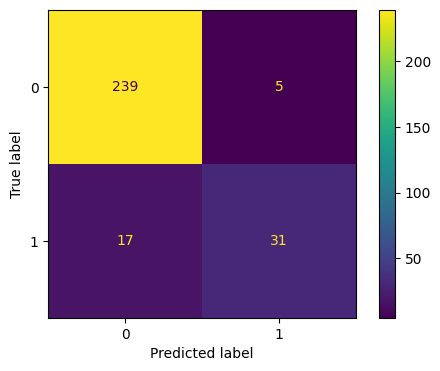

In [55]:
# Logistic Regression Model to Identify Expensive Houses
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_test_expensive, y_test_pred_expensive)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de prueba:
- Para la clase 0 (casas económicas e intermedias), se clasificaron correctamente 239 casos.
- Para la clase 1 (casas de gama alta), se clasificaron correctamente 28 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- El modelo se equivocó más frecuentemente en la predicción de casas de gama alta (clase 1), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas de gama media y baja (clase 0), ya que tiene el menor número de clasificaciones erróneas totales.

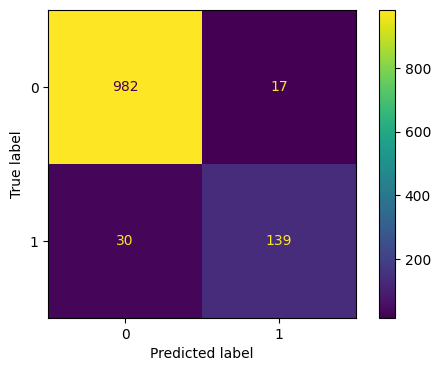

In [56]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_train_expensive, y_train_pred_expensive)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

Sobre el conjunto de datos de entrenamiento:
- Para la clase 0 (casas económicas y de gama media), se clasificaron correctamente 979 casos.
- Para la clase 1 (casas de gama alta), se clasificaron correctamente 20 casos.

En cuanto a las equivocaciones del modelo, se puede observar lo siguiente en la matriz de confusión:
- Nuevamente, el modelo se equivocó más frecuentemente en la predicción de casas de gama alta (clase 1), ya que tiene el mayor número de clasificaciones erroneas.
- El modelo cometió menos equivocaciones en la predicción de casas económicas y de gama media (clase 0), ya que tiene el menor número de clasificaciones erróneas totales.

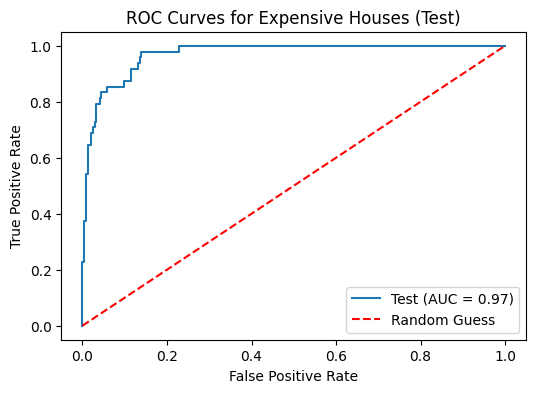

In [57]:
y_pred1 = clf_ex2.predict_proba(X_test_expensive)[:,1]

test_df = pd.DataFrame(
    {'True': y_test_expensive, 'Test': y_pred1})

for model in ['Test']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Expensive Houses (Test)')
plt.legend()
plt.show()

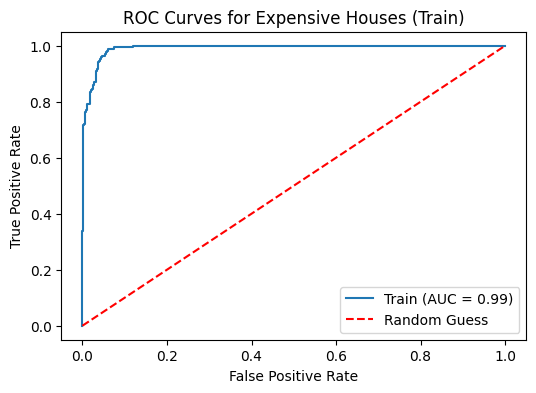

In [58]:
y_pred1 = clf_ex2.predict_proba(X_train_expensive)[:,1]

test_df = pd.DataFrame(
    {'True': y_train_expensive, 'Train': y_pred1})

for model in ['Train']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Expensive Houses (Train)')
plt.legend()
plt.show()

El modelo de regresión logística para clasificar casas de gama alta tiene un rendimiento excelente, como lo indica un AUC de 0.97 en el conjunto de datos de prueba y de 0.98 en el conjunto de entrenamiento.

**AIC y BIC**

In [59]:
X = X_expensive.copy()
y = y_expensive.copy()

for col in X.columns:
    if X[col].dtype == 'object':
        X = pd.concat([X, pd.get_dummies(X[col], prefix=col)], axis=1)
        X.drop([col], axis=1, inplace=True)
    else:
        X[col] = pd.to_numeric(X[col], errors='coerce')

X = X.select_dtypes(['number'])

model = sm.Logit(y, X).fit(method='bfgs')

print("AIC:", model.aic)
print("BIC:", model.bic)

         Current function value: 0.124425
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 41
AIC: 463.3199952675178
BIC: 727.629581002637


### Third Iteration - Identifying House Pricings (With Hyperparameter Tuning & All Features)

In [60]:
# Make another copy of the dataframe
df_cp = df.copy()

# Expensive DataSet Splitting
# Separate the target variable 'SalePriceCategory' from features
y_expensive = df_cp.pop('SalePriceCategory_expensive')

# Exclude columns 'Id' and SalePriceCategory(s) from features
X_expensive = df_cp.loc[:, ~df_cp.columns.isin(['Id', 'SalePrice', 'SalePriceCategory_economical', 'SalePriceCategory_intermediate'])]

In [61]:
# Expensive DataSet Splitting
# Split the data into training and testing sets
X_train_expensive, X_test_expensive, y_train_expensive, y_test_expensive = train_test_split(X_expensive, y_expensive, test_size=0.2, train_size=0.8, random_state=random_state)

In [62]:
from sklearn.linear_model import RidgeClassifier
model = RidgeClassifier()

alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Define grid search
grid = dict(alpha = alpha)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = random_state)

gridSearch = GridSearchCV(estimator = model, param_grid = grid, n_jobs =-1, cv = cv, scoring = 'accuracy', error_score = 0)

def train_model():
    gridResult = gridSearch.fit(X_expensive, y_expensive)
    return gridResult

cProfile.run('gridResult = train_model()')

Best: 0.937900 using {'alpha': 0.9}
0.935388 (0.021995) with: {'alpha': 0.1}
0.935388 (0.022278) with: {'alpha': 0.2}
0.935160 (0.022491) with: {'alpha': 0.3}
0.935388 (0.021564) with: {'alpha': 0.4}
0.936073 (0.021320) with: {'alpha': 0.5}
0.937215 (0.022376) with: {'alpha': 0.6}
0.937443 (0.022281) with: {'alpha': 0.7}
0.937443 (0.022281) with: {'alpha': 0.8}
0.937900 (0.022918) with: {'alpha': 0.9}
0.937671 (0.024012) with: {'alpha': 1.0}


In [ ]:
# Summarize Results
print("Best: %f using %s" % (gridResult.best_score_, gridResult.best_params_))
means = gridResult.cv_results_['mean_test_score']
stds = gridResult.cv_results_['std_test_score']
params = gridResult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [63]:
def evaluate_model():
    # Predict the target variable using the model on the train data
    y_test_pred_expensive = gridSearch.predict(X_test_expensive)
    
    return y_test_pred_expensive

# Predict the target variable using the trained model on the train data
y_train_pred_expensive = gridSearch.predict(X_train_expensive)

cProfile.run('y_test_pred_expensive = evaluate_model()')

         31545 function calls (31425 primitive calls) in 0.057 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.056    0.056 171006683.py:1(evaluate_model)
        2    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        2    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
      306    0.001    0.000    0.001    0.000 <frozen importlib._bootstrap>:1390(_handle_fromlist)
        1    0.000    0.000    0.057    0.057 <string>:1(<module>)
       24    0.000    0.000    0.000    0.000 __init__.py:34(using_copy_on_write)
        2    0.000    0.000    0.000    0.000 _array_api.py:111(_is_numpy_namespace)
        2    0.000    0.000    0.000    0.000 _array_api.py:123(isdtype)
        2    0.000    0.000    0.000    0.000 _array_api.py:130(<genexpr>)
        2    0.000    0.000    0.000    0.000 _array_api.py:135(_isdtype_single)
        2    0.000    0

In [64]:
# Accuracy scores for test set
print("Accuracy Scores on Test Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_test_expensive, y_test_pred_expensive)))
print()

# Accuracy scores for train set
print("Accuracy Scores on Train Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_train_expensive, y_train_pred_expensive)))

Accuracy Scores on Test Set:
---------------------------------------
Expensive Houses Classifier: 0.96

Accuracy Scores on Train Set:
---------------------------------------
Expensive Houses Classifier: 0.95


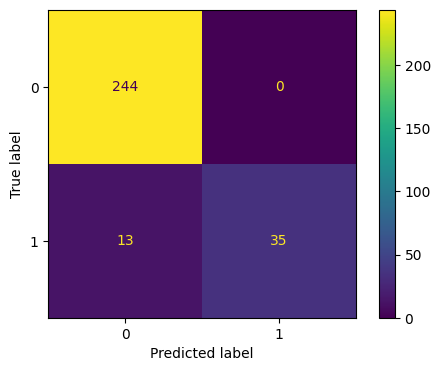

In [65]:
# Logistic Regression Model to Identify Expensive Houses
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_test_expensive, y_test_pred_expensive)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

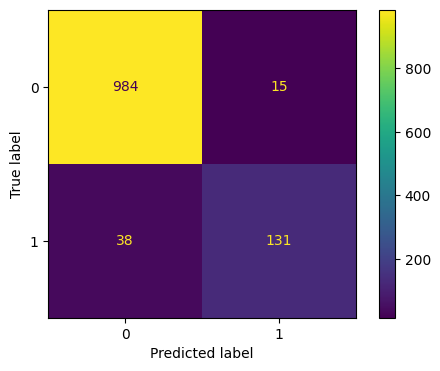

In [66]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_train_expensive, y_train_pred_expensive)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

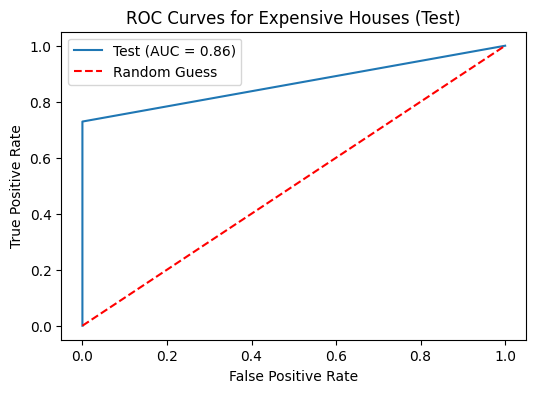

In [67]:
y_pred1 = gridSearch.predict(X_test_expensive)

test_df = pd.DataFrame(
    {'True': y_test_expensive, 'Test': y_pred1})

for model in ['Test']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')
    
# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Expensive Houses (Test)')
plt.legend()
plt.show()

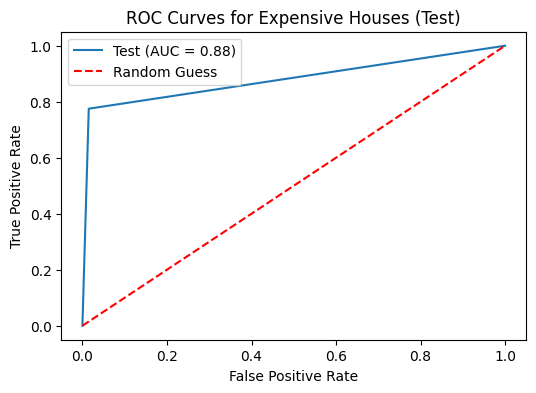

In [68]:
y_pred1 = gridSearch.predict(X_train_expensive)

test_df = pd.DataFrame(
    {'True': y_train_expensive, 'Test': y_pred1})

for model in ['Test']:
    fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')
    
# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Expensive Houses (Test)')
plt.legend()
plt.show()

El modelo de regresión logística para identificar casas caras tiene un rendimiento similar en los conjuntos de entrenamiento y prueba. El modelo tiene un AUC de 0.85 en el conjunto de prueba y 0.86 en el conjunto de entrenamiento, lo que sugiere que no hay sobreajuste. El modelo tiene un rendimiento decente en la identificación de casas caras.

**AIC y BIC**

In [69]:
X = X_expensive.copy()
y = y_expensive.copy()

for col in X.columns:
    if X[col].dtype == 'object':
        X = pd.concat([X, pd.get_dummies(X[col], prefix=col)], axis=1)
        X.drop([col], axis=1, inplace=True)
    else:
        X[col] = pd.to_numeric(X[col], errors='coerce')

X = X.select_dtypes(['number'])

model = sm.Logit(y, X).fit(method='bfgs')

print("AIC:", model.aic)
print("BIC:", model.bic)

         Current function value: 0.125075
         Iterations: 35
         Function evaluations: 51
         Gradient evaluations: 41
AIC: 461.21896576430476
BIC: 714.9561680700191


## Análisis de eficiencia
Para cada uno de los modelos se ha utilizado una matriz de confusión para mostrar su efectividad para identificar las casas más caras. En general, los modelos clasificaron correctamente la siguiente cantidad de casas:
- Primera iteración - All features: 141 
- Segunda iteración - Feature Engineering: 28 
- Tercera iteración - Hyperparameter Tuning & All Features: 131

Por lo que donde se equivocó menos es en el primer modelo con todas las características. Además, según el tiempo de ejecución usando cProfile demuestra que el primer modelo es el que más tiempo demora con alrededor de 7 segundos. Estas dos características pueden ir de la mano porque el modelo toma más tiempo en evaluar y clasificar las casas más caras, por lo que clasificó más casas correctamente.

## Análisis de AIC y BIC

AIC (Criterio de Información de Akaike) al ser una medida de la calidad del modelo que tiene en cuenta tanto la complejidad del modelo (número de parámetros) como la bondad de ajuste. Un valor más bajo indica un mejor modelo. Para cada modelo se obtuvo:
- Primera iteración - All features: 461
- Segunda iteración - Feature Engineering: 463
- Tercera iteración - Hyperparameter Tuning & All Features: 461

Por otro lado BIC (Criterio de Información Bayesiano) es otra medida de la calidad del modelo que también tiene en cuenta la complejidad del modelo y la bondad de ajuste. A diferencia del AIC, el BIC penaliza más fuertemente los modelos más complejos. Al igual que con el AIC, un valor más bajo indica un mejor modelo. Para cada modelo se obtuvo:
- Primera iteración - All features: 714
- Segunda iteración - Feature Engineering: 727
- Tercera iteración - Hyperparameter Tuning & All Features:  714

Por lo que con los resultados obtenidos, los mejores modelos según las métricas AIC y BIC son con todos los features y con el tuneo de hiperparámetros.

## Best Model & Comparisons

El mejor modelo, y aquel que será utilizado en adelante, es el resultado del ajuste de hiperparámetros. Esto se debe a que exhibe los valores más bajos de AIC y BIC, al igual que el modelo obtenido en la primera iteración. La distinción entre ellos radica en el tiempo de aprendizaje, donde el modelo de la tercera iteración se destaca por tener un tiempo de ejecución menor en comparación con el primero, sin comprometer la precisión y el ajuste a los datos.

### Decision Tree

In [87]:
# Create a DecisionTreeRegressor model
dt_clf = DecisionTreeClassifier(random_state=random_state)

def train_model():
    return dt_clf.fit(X_train_expensive, y_train_expensive)

# Profile the function
time = cProfile.run('dt_clf = train_model()', sort='cumulative')

         20045 function calls (19991 primitive calls) in 0.197 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.196    0.196 <string>:1(<module>)
        1    0.000    0.000    0.196    0.196 1671456901.py:4(train_model)
        1    0.000    0.000    0.196    0.196 base.py:1334(wrapper)
        1    0.000    0.000    0.195    0.195 _classes.py:978(fit)
        1    0.097    0.097    0.191    0.191 _classes.py:231(_fit)
        1    0.000    0.000    0.091    0.091 base.py:537(_validate_data)
        4    0.001    0.000    0.089    0.022 validation.py:680(check_array)
      192    0.002    0.000    0.087    0.000 blocks.py:723(astype)
        2    0.001    0.000    0.076    0.038 generic.py:6457(astype)
      192    0.004    0.000    0.075    0.000 astype.py:191(astype_array_safe)
        2    0.000    0.000    0.055    0.027 managers.py:422(astype)
        2    0.001    0.000    0.055    0

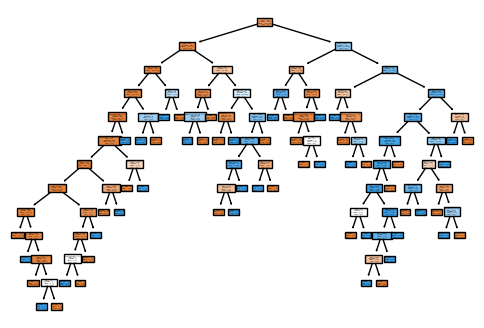

In [71]:
# Plot the decision tree
out = tree.plot_tree(dt_clf, feature_names=X_expensive.columns, class_names=True, filled=True)

In [84]:
def predict():
    dt_y_test_pred = dt_clf.predict(X_test_expensive)
    return dt_y_test_pred

dt_y_train_pred = dt_clf.predict(X_train_expensive)

# Profile the function
cProfile.run('dt_y_test_pred = predict()', sort='cumulative')

         37934 function calls (37814 primitive calls) in 0.070 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.069    0.069 3442755650.py:1(predict)
        2    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        2    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
      306    0.001    0.000    0.001    0.000 <frozen importlib._bootstrap>:1390(_handle_fromlist)
        1    0.000    0.000    0.070    0.070 <string>:1(<module>)
       24    0.000    0.000    0.000    0.000 __init__.py:34(using_copy_on_write)
        2    0.000    0.000    0.000    0.000 _array_api.py:111(_is_numpy_namespace)
        2    0.000    0.000    0.000    0.000 _array_api.py:123(isdtype)
        2    0.000    0.000    0.000    0.000 _array_api.py:130(<genexpr>)
        2    0.000    0.000    0.000    0.000 _array_api.py:135(_isdtype_single)
        2    0.000    0.000  

In [85]:
# Accuracy scores for test set
print("Accuracy Scores on Test Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_test_expensive, dt_y_test_pred)))
print()

# Accuracy scores for test set
print("Accuracy Scores on Train Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_train_expensive, dt_y_train_pred)))
print()

Accuracy Scores on Test Set:
---------------------------------------
Expensive Houses Classifier: 0.93

Accuracy Scores on Train Set:
---------------------------------------
Expensive Houses Classifier: 1.00



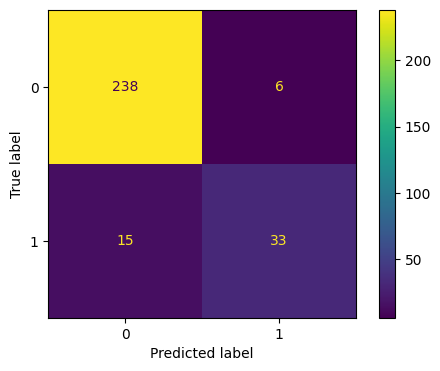

In [86]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_test_expensive, dt_y_test_pred)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

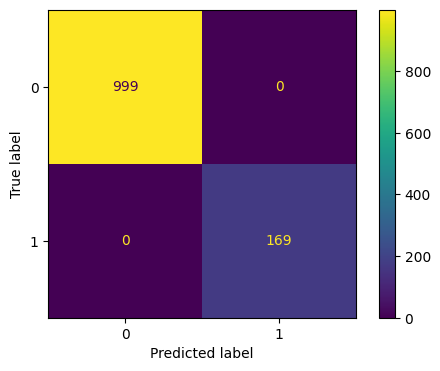

In [88]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_train_expensive, dt_y_train_pred)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

### Random Forest

In [ ]:
# Create a RandomForestClassifier model
rf_clf = RandomForestClassifier(random_state=random_state)

def train_model():
    return rf_clf.fit(X_train_expensive, y_train_expensive)

# Profile the function
cProfile.run('rf_clf = train_model()', sort='cumulative')

         227289 function calls (224434 primitive calls) in 0.381 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    0.124    0.001    0.207    0.002 _classes.py:231(_fit)
      301    0.023    0.000    0.049    0.000 validation.py:1301(check_random_state)
      201    0.018    0.000    0.018    0.000 {function SeedSequence.generate_state at 0x0000023E90AE7A60}
      501    0.015    0.000    0.052    0.000 inspect.py:2366(_signature_from_function)
     7020    0.012    0.000    0.022    0.000 inspect.py:2712(__init__)
      501    0.008    0.000    0.072    0.000 base.py:196(_get_param_names)
      200    0.006    0.000    0.008    0.000 {method 'randint' of 'numpy.random.mtrand.RandomState' objects}
      203    0.006    0.000    0.011    0.000 arraysetops.py:323(_unique1d)
    21583    0.005    0.000    0.008    0.000 {built-in method builtins.isinstance}
15018/15017    0.005    0.000    0.005    0.000 {built-in 

In [ ]:
def predict():
    rf_y_test_pred = rf_clf.predict(X_test_expensive)
    return rf_y_test_pred

rf_y_train_pred = rf_clf.predict(X_train_expensive)

cProfile.run('rf_y_test_pred = predict()', sort='cumulative')

In [ ]:
# Accuracy scores for test set
print("Accuracy Scores on Test Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_test_expensive, rf_y_test_pred)))
print()

# Accuracy scores for test set
print("Accuracy Scores on Train Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_train_expensive, rf_y_train_pred)))
print()

         30875 function calls (30814 primitive calls) in 0.033 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.033    0.033 835580308.py:1(predict)
        2    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        1    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
      153    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1390(_handle_fromlist)
      200    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:645(parent)
        1    0.000    0.000    0.033    0.033 <string>:1(<module>)
       12    0.000    0.000    0.000    0.000 __init__.py:34(using_copy_on_write)
        1    0.000    0.000    0.000    0.000 _array_api.py:111(_is_numpy_namespace)
        1    0.000    0.000    0.000    0.000 _array_api.py:123(isdtype)
        1    0.000    0.000    0.000    0.000 _array_api.py:130(<genexpr>)
        1    0.000    0

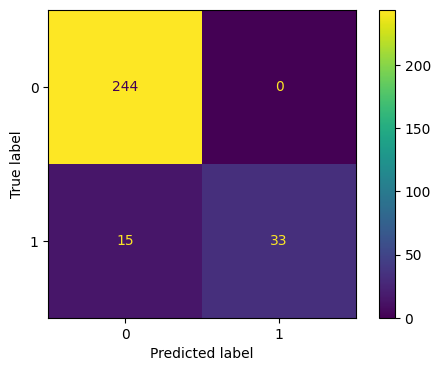

In [ ]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_test_expensive, rf_y_test_pred)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

In [ ]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_train_expensive, rf_y_train_pred)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

### Naïve Bayes

In [ ]:
# Create a GaussianNB model
nb_clf = GaussianNB()

def train_model():
    return nb_clf.fit(X_train_expensive, y_train_expensive)

# Profile the function
cProfile.run('nb_clf = train_model()')

         16308 function calls (16255 primitive calls) in 0.032 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.028    0.028 3752836651.py:4(train_model)
        6    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        4    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
      155    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1390(_handle_fromlist)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:645(parent)
        1    0.000    0.000    0.029    0.029 <string>:1(<module>)
       15    0.000    0.000    0.000    0.000 __init__.py:34(using_copy_on_write)
        7    0.000    0.000    0.000    0.000 _array_api.py:111(_is_numpy_namespace)
        4    0.000    0.000    0.000    0.000 _array_api.py:123(isdtype)
        7    0.000    0.000    0.000    0.000 _array_api.py:130(<genexpr>)
        6    0.000

In [ ]:
def predict():
    nb_y_test_pred = nb_clf.predict(X_test_expensive)
    return nb_y_test_pred

nb_y_train_pred = nb_clf.predict(X_train_expensive)

# Profile the function
cProfile.run('nb_y_test_pred, nb_y_train_pred = predict()')

In [ ]:
# Accuracy scores for test set
print("Accuracy Scores on Test Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_test_expensive, nb_y_test_pred)))
print()

# Accuracy scores for test set
print("Accuracy Scores on Train Set:")
print("---------------------------------------")
print("Expensive Houses Classifier: {:.2f}".format(accuracy_score(y_train_expensive, nb_y_train_pred)))
print()

         15364 function calls (15304 primitive calls) in 0.017 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.017    0.017 798558308.py:1(predict)
        1    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
        1    0.000    0.000    0.000    0.000 <frozen abc>:121(__subclasscheck__)
      153    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1390(_handle_fromlist)
        1    0.000    0.000    0.017    0.017 <string>:1(<module>)
       12    0.000    0.000    0.000    0.000 __init__.py:34(using_copy_on_write)
        1    0.000    0.000    0.000    0.000 _array_api.py:111(_is_numpy_namespace)
        1    0.000    0.000    0.000    0.000 _array_api.py:123(isdtype)
        1    0.000    0.000    0.000    0.000 _array_api.py:130(<genexpr>)
        1    0.000    0.000    0.000    0.000 _array_api.py:135(_isdtype_single)
        1    0.000    0.000   

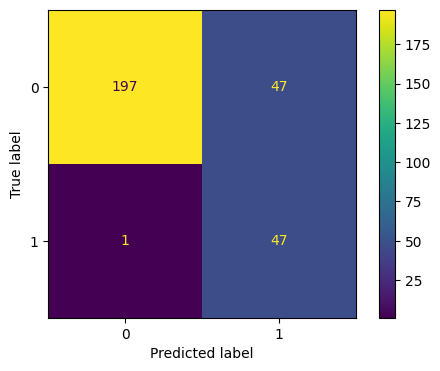

In [ ]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_test_expensive, nb_y_test_pred)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()

In [ ]:
# Calculating the confusion matrix using the true labels and predicted labels
confusionMatrix = confusion_matrix(y_train_expensive, nb_y_train_pred)
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

# Plotting the confusion matrix
cmDisplay.plot()
plt.show()